# <center> Final training of Age estimation model </center>



In [1]:
!pip install GitPython
from git import Repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.8 MB/s 
     |████████████████████████████████| 62 kB 772 kB/s 


In [2]:
!pip install wget wfdb neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 159 kB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.6 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=a4c569324f922128acd818e4ba2e5de673637d33e22f671e952bd21fc47e5d72
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json'

kaggle.json
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [4]:
!kaggle datasets download -d bjoernjostein/georgia-12lead-ecg-challenge-database
!kaggle datasets download -d bjoernjostein/st-petersburg-incart-12lead-arrhythmia-database
!kaggle datasets download -d bjoernjostein/china-12lead-ecg-challenge-database
!kaggle datasets download -d bjoernjostein/china-physiological-signal-challenge-in-2018
!kaggle datasets download -d erarayamorenzomuten/chapmanshaoxing-12lead-ecg-database
!kaggle datasets download -d erarayamorenzomuten/ningbo-first-hospital-12lead-ecg-database

!kaggle datasets download -d bjoernjostein/physionet-challenge-2021-snomed-mappings

 97% 466M/483M [00:03<00:00, 134MB/s]
100% 483M/483M [00:03<00:00, 148MB/s]
 97% 546M/564M [00:03<00:00, 191MB/s]
100% 564M/564M [00:03<00:00, 154MB/s]
 97% 394M/406M [00:02<00:00, 174MB/s]
100% 406M/406M [00:02<00:00, 161MB/s]
 98% 811M/824M [00:04<00:00, 166MB/s]
100% 824M/824M [00:04<00:00, 174MB/s]
100% 545M/547M [00:04<00:00, 151MB/s]
100% 547M/547M [00:04<00:00, 121MB/s]
100% 1.77G/1.78G [00:11<00:00, 217MB/s]
100% 1.78G/1.78G [00:11<00:00, 165MB/s]
  0% 0.00/4.13k [00:00<?, ?B/s]
100% 4.13k/4.13k [00:00<00:00, 4.68MB/s]


In [5]:
import os, zipfile

dir_name = "./"
extension = ".zip"
 
os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [6]:
HTTPS_REMOTE_URL = 'https://github.com/Bsingstad/ECG-age.git'
DEST_NAME = 'ecg_age'
cloned_repo = Repo.clone_from(HTTPS_REMOTE_URL, DEST_NAME)

In [7]:
import shutil
import os
os.mkdir("/content/ecg_age/data")
sources = ['Training_2/',  'Training_StPetersburg/','Training_WFDB/','WFDB_ChapmanShaoxing/', 'WFDB_Ningbo/', "WFDB/"]
dest1 = '/content/ecg_age/data/'


for s in sources:
  files = os.listdir(s)
  for f in files:
      shutil.move(s+f, dest1)

In [8]:
from ecg_age.src.helpers.helpers import *
from ecg_age.src.models.models import *

In [9]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tqdm
from scipy import signal
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload
%reload_ext autoreload
sns.set_style("dark")

In [10]:
######################################################
print("Collecting labels, ECG filenames and metadata...")
gender, age, labels, ecg_len, ecg_filenames = import_key_data("/content/ecg_age/data/")
ecg_filenames = np.asarray(ecg_filenames)
age = np.asarray(age)
gender = np.asarray(gender)
ecg_len = np.asarray(ecg_len)
labels = np.asarray(labels)
print(f"Total number of patients found: {len(age)}")

100%|██████████| 131800/131800 [00:32<00:00, 4010.55it/s]

Total number of patients found: 59490


In [11]:
#####################################################
print("remove all ECGs not equal to 10 seconds")
age, gender,ecg_filenames, labels = only_ten_sec(ecg_len, age, gender, ecg_filenames, labels)

remove all ECGs not equal to 10 seconds


In [12]:
print("remove all ECGs with missing values in gender or age")
ecg_filenames, gender, age, labels = remove_nan_and_unknown_values(ecg_filenames, gender, age, labels)

remove all ECGs with missing values in gender or age


In [13]:
age = clean_up_age_data(age)
gender = clean_up_gender_data(gender)

print(f"Total number of patients left after data cleaning: {len(age)}")

Total number of patients left after data cleaning: 59355


In [14]:
print("Select ECGs from males or females")
gender_choice = "both"

if gender_choice == "female":
    gender, age, ecg_filenames, labels = male_or_female(gender, age, ecg_filenames, labels, g="female")
elif gender_choice == "male":
    gender, age, ecg_filenames, labels = male_or_female(gender, age, ecg_filenames, labels, g="male")
else:
    print("Train on both male and female")
    pass

Select ECGs from males or females
Train on both male and female


In [15]:
print(f"Total number of patients left after selection and data cleaning: {len(age)}")

Total number of patients left after selection and data cleaning: 59355


In [16]:
#TODO: update this acording to the optimal learning rate schedule found in hyperparameter opt.
def scheduler(epoch, lr):
    if epoch == 10:
        return lr * 0.1
    elif epoch == 15:
        return lr * 0.1
    elif epoch == 20:
        return lr * 0.1
    else:
        return lr

In [17]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [18]:
model_name = "inception" # or "inception"

In [ ]:
samp_freq = 100
time = 10
num_leads = 12
batchsize = 16
epoch = 20
mae_score_total = []

print("Training model...")

#Chose model:
if model_name == "attia":
    model = attia_model(samp_freq, time, num_leads)
elif model_name == "inception":
    model = build_model((samp_freq*time,num_leads), 1)
model.fit(x=shuffle_batch_generator_age(batch_size=batchsize, gen_x=generate_X_age(ecg_filenames,samp_freq=samp_freq,num_leads=num_leads), gen_y=generate_y_age(age),num_leads=num_leads, time=time, samp_freq=samp_freq), epochs=epoch, 
            steps_per_epoch=(len(ecg_filenames)/batchsize), 
            verbose = 1, 
            callbacks=[lr_schedule]
            )

Training model...
Epoch 1/20
1083/1083 [==============================] - 143s 119ms/step - loss: 1342.2295 - mean_absolute_error: 29.7201 - val_loss: 214.4473 - val_mean_absolute_error: 11.5169 - lr: 0.0010
Epoch 2/20
1083/1083 [==============================] - 60s 56ms/step - loss: 238.8643 - mean_absolute_error: 12.0604 - val_loss: 179.4969 - val_mean_absolute_error: 10.3433 - lr: 0.0010
Epoch 3/20
1083/1083 [==============================] - 60s 55ms/step - loss: 220.2294 - mean_absolute_error: 11.5442 - val_loss: 221.8054 - val_mean_absolute_error: 11.8596 - lr: 0.0010
Epoch 4/20
1083/1083 [==============================] - 61s 56ms/step - loss: 209.3514 - mean_absolute_error: 11.2443 - val_loss: 166.7784 - val_mean_absolute_error: 10.0193 - lr: 0.0010
Epoch 5/20
1083/1083 [==============================] - 64s 60ms/step - loss: 200.7987 - mean_absolute_error: 10.9663 - val_loss: 196.4565 - val_mean_absolute_error: 10.7758 - lr: 0.0010
Epoch 6/20
1084/1083 [======================

In [ ]:
model.save_weights("model_weights_" + model_name + gender_choice + ".h5")

In [111]:
def import_ecg_data(filenames, samp_freq=100,time=10,num_leads=1):
  all_data = np.zeros((len(filenames), samp_freq * time, num_leads))
  cnt = 0
  print("Load ECGs...")
  for filename in tqdm.tqdm(filenames):
    data, header_data = load_challenge_data(filename)
    if int(header_data[0].split(" ")[2]) != samp_freq:
        data_new = np.ones(
            [
                num_leads,
                int(
                    (
                        int(header_data[0].split(" ")[3])
                        / int(header_data[0].split(" ")[2])
                    )
                    * samp_freq
                ),
            ]
        )
        data = data[0,:]
        data = np.expand_dims(data,1)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)
        data_new = signal.resample(
            scaled_data[:,0], #scaled_data[0],
            int(
                (
                    int(header_data[0].split(" ")[3])
                    / int(header_data[0].split(" ")[2])
                )
                * samp_freq
            ),
        )
    data = data_new
    if len(data) > 1000:
      data = data[:1000]
    
    #plt.plot(data[0])
    #plt.show()
    #data = pad_sequences(np.expand_dims(data,0), maxlen=samp_freq * 10, truncating="post", padding="post")


    all_data[cnt] = np.expand_dims(data,1)
    cnt += 1
  return all_data

    

In [112]:
ecg_data = import_ecg_data(ecg_filenames)

Load ECGs...


100%|██████████| 59355/59355 [00:56<00:00, 1045.49it/s]


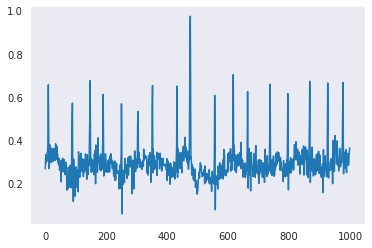

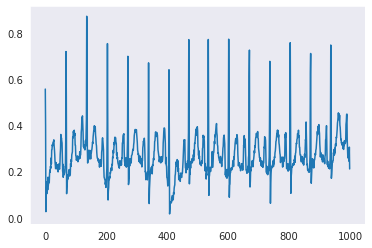

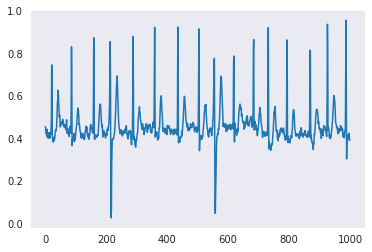

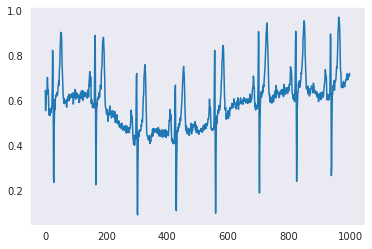

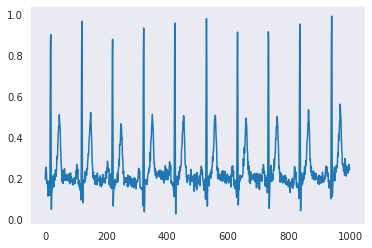

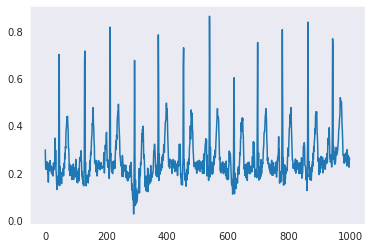

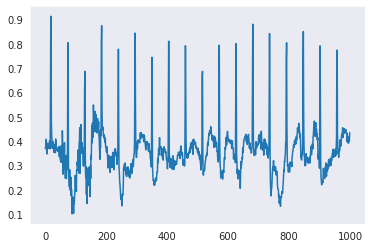

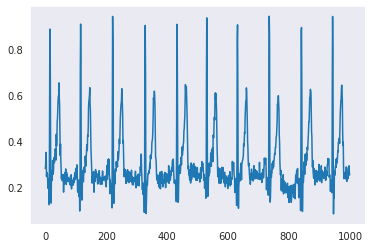

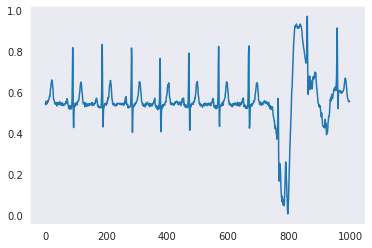

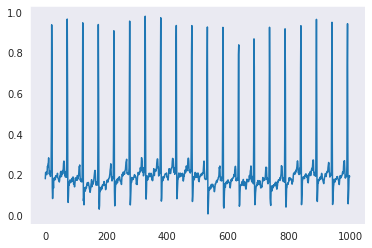

In [113]:
for i in range(10):
  plt.plot(ecg_data[i])
  plt.show()

# One lead model

In [ ]:
samp_freq = 100
time = 10
num_leads = 1
batchsize = 16
epoch = 2
mae_score_total = []

print("Training model...")

model = build_model((samp_freq*time,num_leads), 1)
model.fit(x=ecg_data, y=age,  epochs=epoch, batch_size = batchsize,
            steps_per_epoch=(len(ecg_filenames)/batchsize), validation_split=0.25,
            verbose = 1, 
            callbacks=[lr_schedule], shuffle=True
            )

Training model...
Epoch 1/2
 608/3709 [===>..........................] - ETA: 2:02 - loss: 23.4943 - mean_squared_error: 915.3134

In [26]:
model.save_weights("model_weights_leadI.h5")

In [ ]:
samp_freq = 100
time = 10
num_leads = 1
batchsize = 16
epoch = 20
mae_score_total = []

print("Training model...")

#Chose model:
if model_name == "attia":
    model = attia_model(samp_freq, time, num_leads)
elif model_name == "inception":
    model = build_model((samp_freq*time,num_leads), 1)
model.fit(x=shuffle_batch_generator_age(batch_size=batchsize, gen_x=generate_X_age_leadII(ecg_filenames,samp_freq=samp_freq,num_leads=num_leads), gen_y=generate_y_age(age),num_leads=num_leads, time=time, samp_freq=samp_freq), epochs=epoch, 
            steps_per_epoch=(len(ecg_filenames)/batchsize), 
            verbose = 1, 
            callbacks=[lr_schedule]
            )

Training model...
Epoch 1/20
3709/3709 [==============================] - 201s 51ms/step - loss: 13.4705 - mean_squared_error: 338.3437 - lr: 0.0010
Epoch 2/20
3709/3709 [==============================] - 183s 49ms/step - loss: 11.1472 - mean_squared_error: 212.8690 - lr: 0.0010
Epoch 3/20
3709/3709 [==============================] - 186s 50ms/step - loss: 10.8878 - mean_squared_error: 204.0135 - lr: 0.0010
Epoch 4/20
3709/3709 [==============================] - 187s 50ms/step - loss: 10.7418 - mean_squared_error: 199.4563 - lr: 0.0010
Epoch 5/20
3709/3709 [==============================] - 188s 51ms/step - loss: 10.5853 - mean_squared_error: 194.4694 - lr: 0.0010
Epoch 6/20
3709/3709 [==============================] - 188s 51ms/step - loss: 10.4451 - mean_squared_error: 190.2847 - lr: 0.0010
Epoch 7/20
3709/3709 [==============================] - 190s 51ms/step - loss: 10.3771 - mean_squared_error: 188.2918 - lr: 0.0010
Epoch 8/20
3709/3709 [==============================] - 192s 52ms

In [ ]:
model.save_weights("model_weights_leadII.h5")

In [ ]:
data, header_data = load_challenge_data(ecg_filenames[0])

In [ ]:
data = np.expand_dims(data[1,:],0)

In [ ]:
np.expand_dims(data[1,:],0)

In [ ]:
new_data = np.ones(1,1000)

TypeError: ignored

In [ ]:
data_new = signal.resample(data,1000)

In [ ]:
                   data_new[i] = signal.resample(
                        j,
                        int(
                            (
                                int(header_data[0].split(" ")[3])
                                / int(header_data[0].split(" ")[2])
                            )
                            * samp_freq
                        ),
                    )